# Imports and setup

In [1]:
from torch import nn, optim
import torch

from torch.utils.data import DataLoader
from torchvision import models
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt

import lpips
import time

/home/e20220005499/Documents/Face-Swap-M2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [3]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


### classe pour mesurer le temps d'entrainement restant

In [4]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset

In [5]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [6]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)


Building dataset 



# Paramètres

In [7]:

EMBEDDING_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 100

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -0.929411768913269
Max pixel value: 1.0
Mean pixel value: 0.032017555087804794


train samples: 67, test samples: 20, nb_classes: 10
train Class 0: 8 samples
train Class 1: 7 samples
train Class 2: 7 samples
train Class 3: 5 samples
train Class 4: 4 samples
train Class 5: 7 samples
train Class 6: 8 samples
train Class 7: 7 samples
train Class 8: 8 samples
train Class 9: 6 samples
Test Class 0: 2 samples
Test Class 1: 2 samples
Test Class 2: 2 samples
Test Class 3: 2 samples
Test Class 4: 2 samples
Test Class 5: 2 samples
Test Class 6: 2 samples
Test Class 7: 2 samples
Test Class 8: 2 samples
Test Class 9: 2 samples


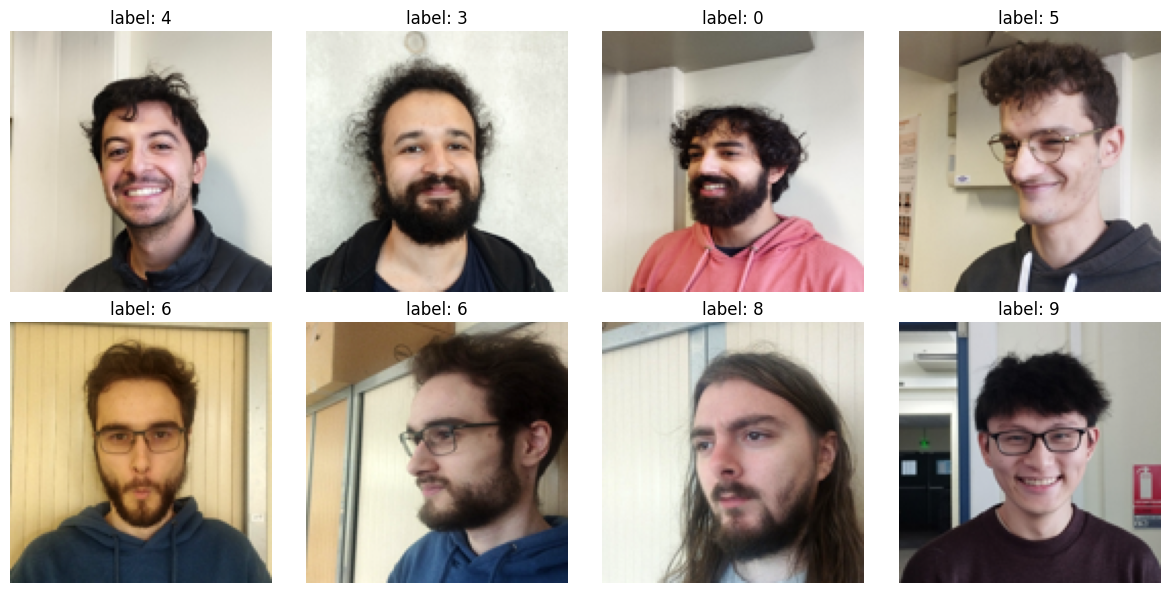

In [10]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Définition des modèles

In [11]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Increased filters for better feature extraction
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Increased filters for deeper feature representation
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Added another convolutional layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),  # Added intermediate fully connected layer
            nn.ReLU(),
            nn.Linear(256, EMBEDDING_SIZE)
        )

    def forward(self, x):
        res = self.conv(x)
        res = torch.flatten(res, 1)
        res = self.fc(res)
        res = res / res.norm(dim=1, keepdim=True).clamp(min=1e-6)  # Normalize the output
        return res

class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)



# Chargement Embedder

In [12]:
faceEmbedder = Embedder().to(device)

embedder_path = "models/embedder_150.pth"
#faceEmbedder.load_state_dict(torch.load(embedder_path))
faceEmbedder.eval()

Embedder(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

## Analyse

### Calcul tous les embeddings

In [13]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

classe 0: avg embedding = [0.13355913199484348, -0.09627898782491684, -0.15722913667559624, -0.05395080288872123, 0.10216914676129818, -0.056336665991693735, 0.10789444949477911, -0.11622917279601097, -0.0658792881295085, 0.02488311706110835, 0.12135976180434227, -0.05646006157621741, 0.07594977132976055, -0.11366943642497063, -0.03894959483295679, -0.025380342616699636, 0.04340616427361965, -0.019538506399840117, 0.07507598213851452, -0.020997652085497975, -0.15865539945662022, -0.07510261842980981, -0.031666234601289034, 0.1435199584811926, 0.08504139166325331, -0.12181417644023895, -0.06393046397715807, -0.13471282180398703, 0.023429283872246742, 0.04525353666394949, -0.12266234122216702, -0.014884388190694153, 0.11088189203292131, -0.1889841090887785, 0.08092199265956879, 0.06550108455121517, 0.008932831755373627, 0.057770511135458946, 0.11899689864367247, 0.122709053568542, 0.04879623372107744, 0.11593583133071661, -0.13132176082581282, -0.0676268432289362, -0.0034114243171643466,

In [15]:
import math

faceEmbedder.eval()

correct = 0
total = 0
avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min == labels[0].item():
            correct += 1

        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0 
print(f"accuracy: {accuracy:.4f}, {correct} / {total}")


accuracy: 0.5000, 10 / 20


### Plot embeddings

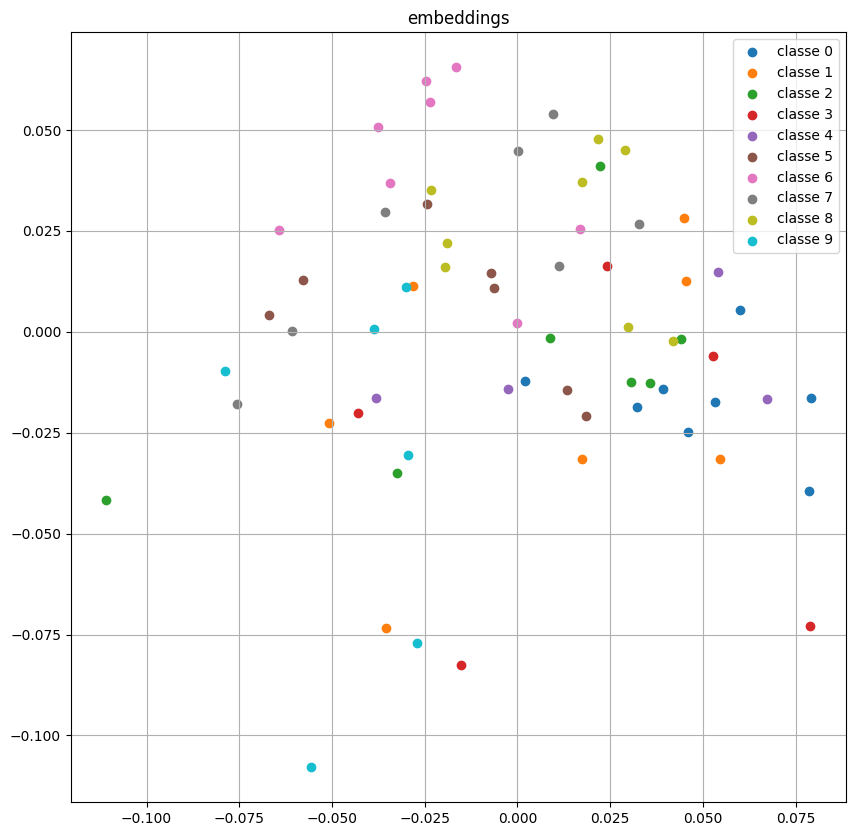

In [16]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [15]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(EPOCHS):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

Epoch 1, training loss: 2.2966, test loss: 2.2882
Epoch 2, training loss: 2.2711, test loss: 2.2699
Epoch 3, training loss: 2.2487, test loss: 2.2525
Epoch 4, training loss: 2.2226, test loss: 2.2353
Epoch 5, training loss: 2.1990, test loss: 2.2180
Epoch 6, training loss: 2.1716, test loss: 2.2007
Epoch 7, training loss: 2.1470, test loss: 2.1835
Epoch 8, training loss: 2.1295, test loss: 2.1664
Epoch 9, training loss: 2.1029, test loss: 2.1494
Epoch 10, training loss: 2.0852, test loss: 2.1324
Epoch 11, training loss: 2.0573, test loss: 2.1156
Epoch 12, training loss: 2.0327, test loss: 2.0988
Epoch 13, training loss: 2.0148, test loss: 2.0821
Epoch 14, training loss: 1.9913, test loss: 2.0657
Epoch 15, training loss: 1.9704, test loss: 2.0494
Epoch 16, training loss: 1.9468, test loss: 2.0331
Epoch 17, training loss: 1.9266, test loss: 2.0170
Epoch 18, training loss: 1.8989, test loss: 2.0010
Epoch 19, training loss: 1.8802, test loss: 1.9851
Epoch 20, training loss: 1.8546, test lo

## Analyse

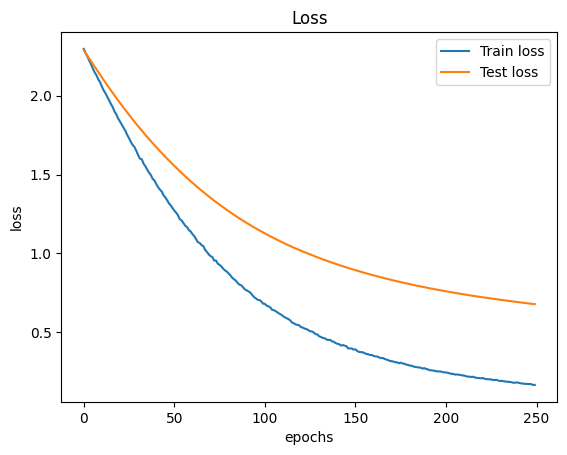

In [16]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

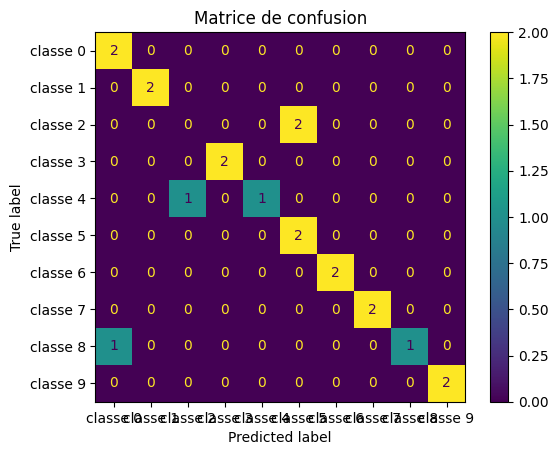

accuracy on test set: 80.00% (16/20)


In [17]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

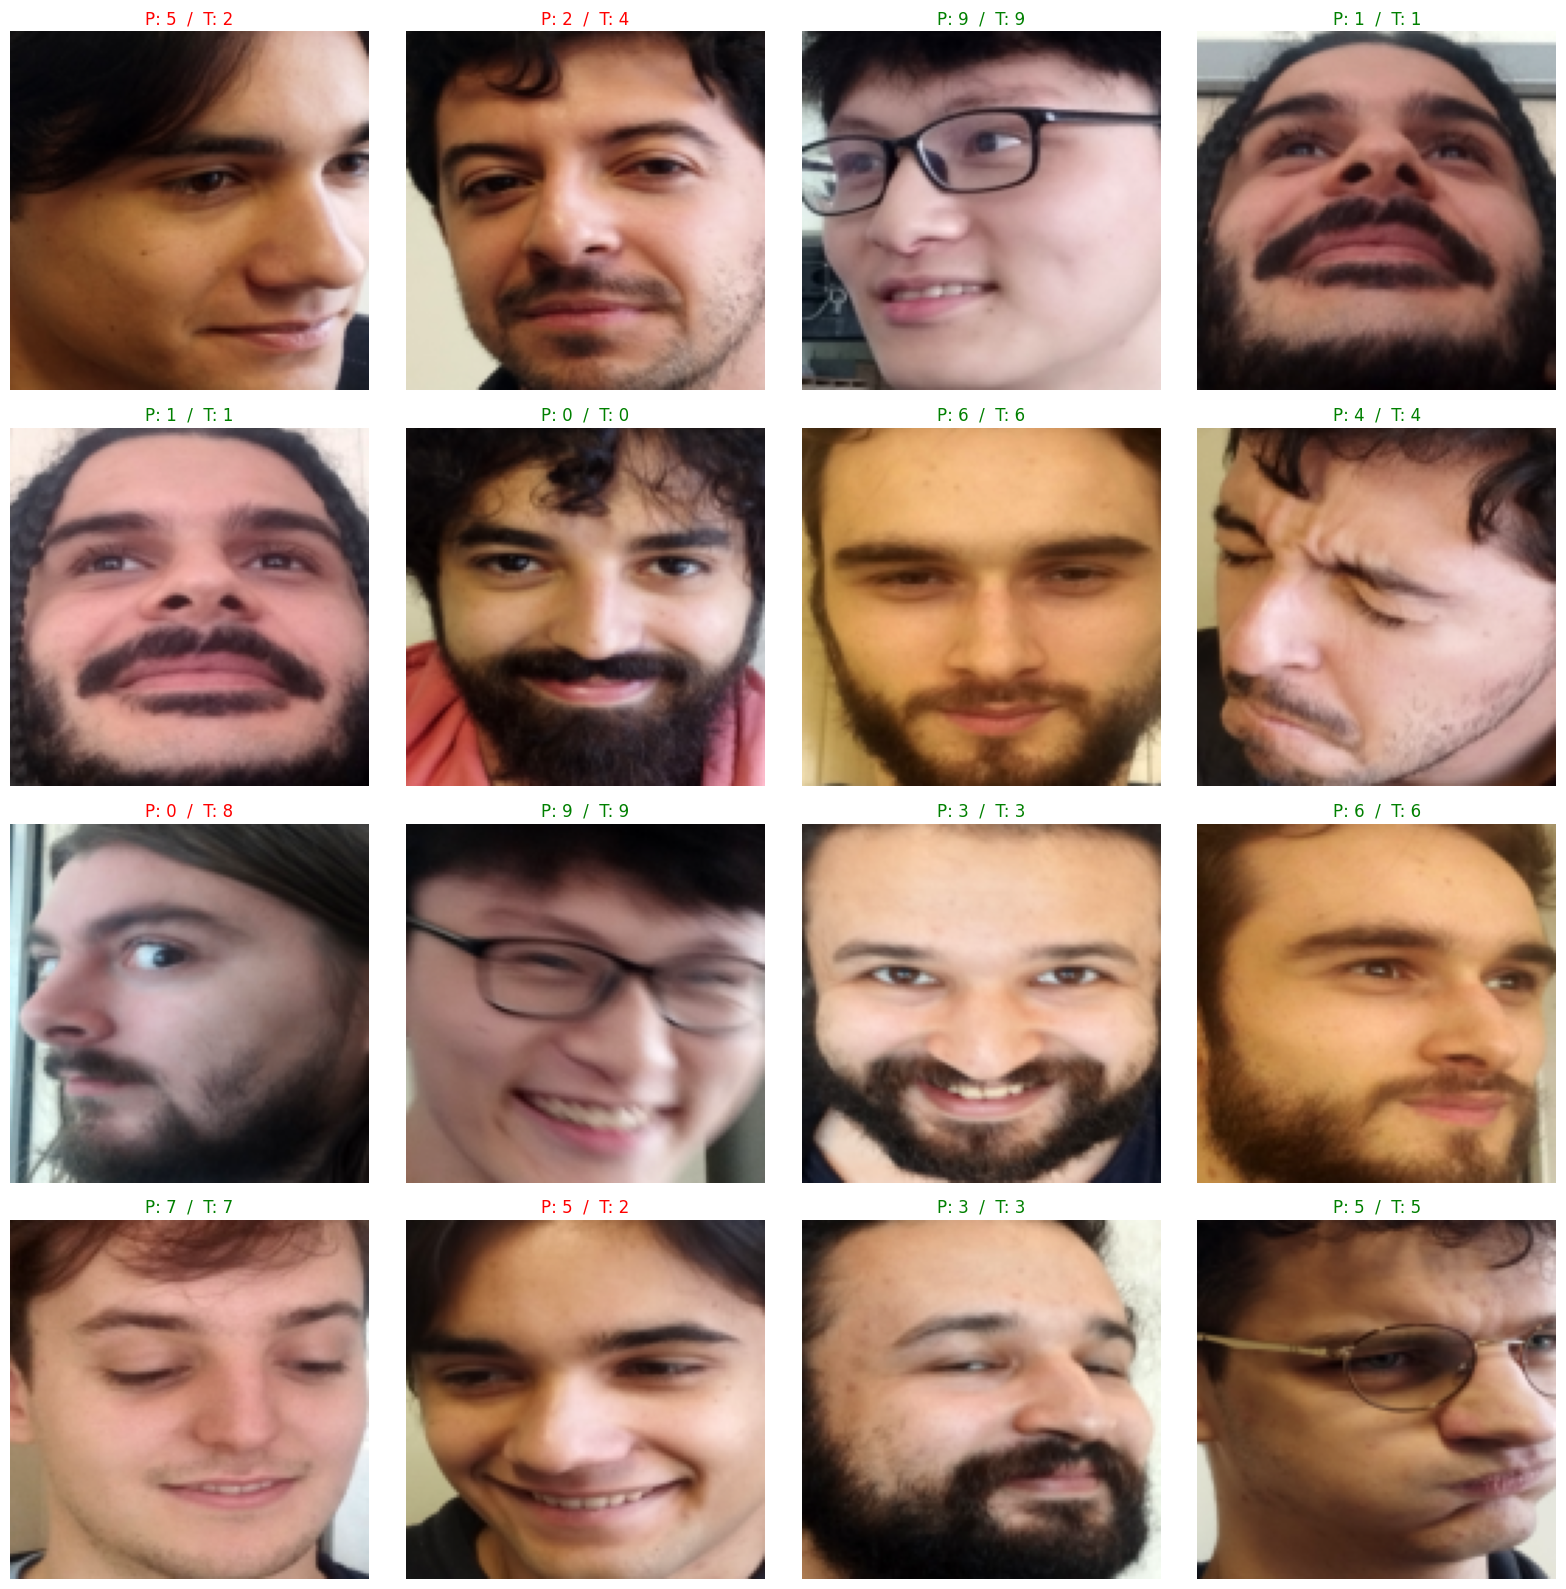

In [18]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()